In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [17]:
base_dir = 'times'
figures_dir = 'figures'
hosts = ['macbook', 'iw5', 'threadripper00', 'threadripper02','Carl9800']
hosts_labels = ['MacBook Pro', 'Intel W5-2445', 'AMD Threadripper 1950X', 'AMD Threadripper 7975WX', 'AMD Ryzen 7 9800x3D']
sizes = ['small', 'medium', 'large']
benchmarks = ['full', 'partial', 'no', 'metadata']
benchmarks_labels = ['Full restore', 'Partial restore', 'No restore', 'Metadata only']
#legacies = ['ancient', 'true', 'false']
legacies = ['true', 'false']
sparsity_size = 'small'
filesize_size = 'small'

# Load the regular runs
runs = dict()
for host in hosts:
    runs[host] = dict()
    for size in sizes:
        runs[host][size] = dict()
        for benchmark in benchmarks:
            runs[host][size][benchmark] = dict()
            for legacy in legacies:
                with open(f'{base_dir}/{host}_{size}_{benchmark}_{legacy}.csv', 'r') as f:
                    lines = np.array([float(line.strip()) for line in f.readlines()])
                    runs[host][size][benchmark][legacy] = lines / 1000

# Load the sparsity runs
for host in hosts[:1]:
    if host not in runs: runs[host] = dict()
    if sparsity_size not in runs[host]: runs[host][sparsity_size] = dict()
    if 'sparse' not in runs[host][sparsity_size]: runs[host][sparsity_size]['sparse'] = dict()
    for legacy in legacies:
        runs[host][sparsity_size]['sparse'][legacy] = dict()
        with open(f'{base_dir}/{host}_{sparsity_size}_sparse_{legacy}.csv', 'r') as f:
            lines = np.array([[float(elem) for elem in line.strip().split(';')] for line in f.readlines()])
            runs[host][sparsity_size]['sparse'][legacy] = lines / 1000

# Load the filesizes runs
#for host in hosts:
#    if host not in runs: runs[host] = dict()
#    if filesize_size not in runs[host]: runs[host][filesize_size] = dict()
#    if 'filesize' not in runs[host][filesize_size]: runs[host][filesize_size]['filesize'] = dict()
#    for legacy in legacies:
#        runs[host][filesize_size]['filesize'][legacy] = dict()
#        with open(f'{base_dir}/{host}_{filesize_size}_size_{legacy}.csv', 'r') as f:
#            lines = np.array([[float(elem) for elem in line.strip().split(';')] for line in f.readlines()])
#            runs[host][filesize_size]['filesize'][legacy] = lines

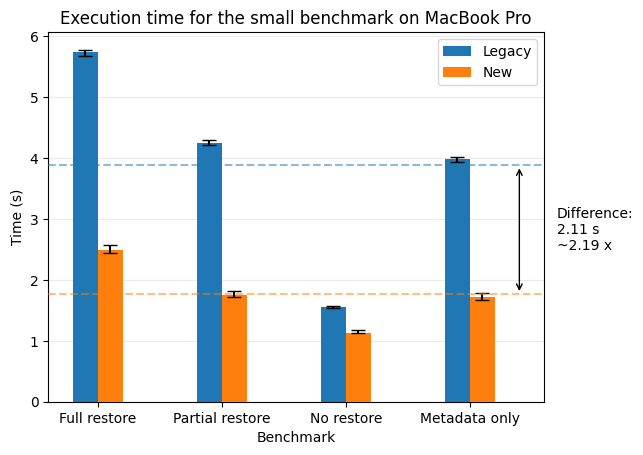

In [18]:
def clean(times):
    if len(times) == 1:
        return times[0], times[0], times[0]
    no_outliers = np.sort(times)[1:-1]
    return np.mean(no_outliers), np.min(no_outliers), np.max(no_outliers)

def plot_bars_regular(runs, host, size, host_label, omit_title=False):
    width = .2
    off = -width
    super_means = []
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for l in legacies:
        means = []
        mins = []
        maxs = []
        for b in benchmarks:
            mean, mi, ma = clean(runs[host][size][b][l])
            means.append(mean)
            mins.append(mi)
            maxs.append(ma)

        super_means.append(np.mean(means))
        means = np.array(means)
        mins = np.array(mins)
        maxs = np.array(maxs)

        if l == 'true':
            label = 'Legacy'
        elif l == 'false':
            label = 'New'
        else:
            label = 'Ancient'
        plt.bar(np.arange(len(benchmarks)) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=.2, label=label, zorder=3)
        off += width
    plt.legend()

    plt.hlines(super_means[0], -.5, len(benchmarks)-.5, colors=colors[0], alpha=.5, linestyles='dashed', label='Legacy mean', zorder=4)
    plt.hlines(super_means[1], -.5, len(benchmarks)-.5, colors=colors[1], alpha=.5, linestyles='dashed', label='New mean', zorder=4)
    #plt.hlines(super_means[2], -.5, len(benchmarks)-.5, colors=colors[2], alpha=.5, linestyles='dashed', label='New mean', zorder=4)

    # Highlight the difference between the two means
    average_speedup = super_means[0]/super_means[1]
    plt.annotate('', xy=(3.3, super_means[1]), xytext=(3.3, super_means[0]), arrowprops=dict(arrowstyle='<->', color='black'))
    plt.text(3.6, (super_means[0]+super_means[1])/2, f'Difference:\n{np.abs(super_means[1]-super_means[0]):.2f} s\n~{average_speedup:.2f} x', verticalalignment='center', horizontalalignment='left')

    #plt.annotate('', xy=(3.3, super_means[2]), xytext=(3.3, super_means[1]), arrowprops=dict(arrowstyle='<->', color='black'))
    #plt.text(3.6, (super_means[1]+super_means[2])/2, f'Difference:\n{np.abs(super_means[2]-super_means[1]):.2f} ms\n~{super_means[1]/super_means[2]:.2f} x', verticalalignment='center', horizontalalignment='left')

    #plt.text(3.6, super_means[2]/2, f'Total:\n{np.abs(super_means[2]-super_means[0]):.2f} ms\n~{super_means[0]/super_means[2]:.2f} x', verticalalignment='center', horizontalalignment='left')

    plt.xticks(np.arange(len(benchmarks))-.5*width, benchmarks_labels)
    plt.xlim(-.5, len(benchmarks)-.5)
    plt.ylabel('Time (s)')
    plt.xlabel('Benchmark')
    if not omit_title:
        plt.title(f'Execution time for the {size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

    return average_speedup

plot_bars_regular(runs, hosts[0], 'small', hosts_labels[0])
plt.show()

In [5]:
if not os.path.exists(figures_dir):
    os.mkdir(figures_dir)

speedups = []
for host, host_label in zip(hosts, hosts_labels):
    for size in sizes:
        speedup = plot_bars_regular(runs, host, size, host_label)
        speedups.append(speedup)
        # More horizontal space for the legend
        plt.tight_layout(rect=[0, 0, 1, .9])
        plt.savefig(f'{figures_dir}/{host}_{size}.png', dpi=300)
        plt.clf()

print (sum(speedups)/len(speedups))

for host, host_label in zip(hosts, hosts_labels):
    plt.figure(figsize=(19.2, 4.8))
    for col in range(len(sizes)):
        plt.subplot(1, 3, col+1)
        plot_bars_regular(runs, host, sizes[col], host_label)
        #if col == 1:
        #    plt.title(f'Execution time for the {host_label}')
    plt.tight_layout(rect=[0, 0, 1, .9])
    plt.savefig(f'{figures_dir}/{host}_all.png', dpi=300)
    plt.clf()

3.8017249859242983


<Figure size 640x480 with 0 Axes>

<Figure size 1920x480 with 0 Axes>

<Figure size 1920x480 with 0 Axes>

<Figure size 1920x480 with 0 Axes>

<Figure size 1920x480 with 0 Axes>

<Figure size 1920x480 with 0 Axes>

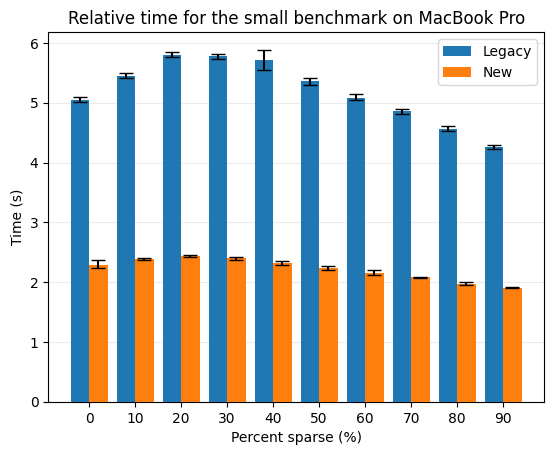

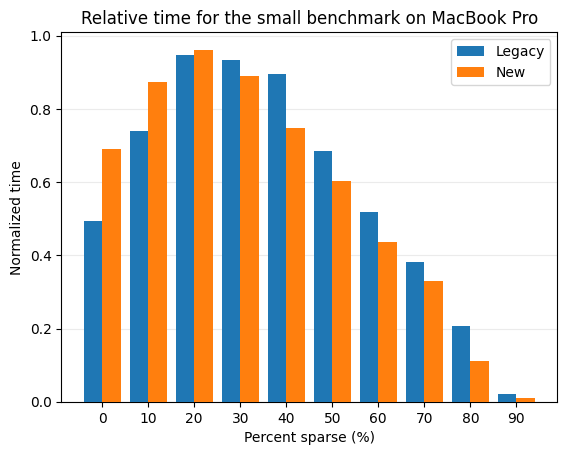

In [6]:
def plot_bars_sparse(runs, host, host_label, normalized):
    width = 4
    off = -(.5*width)

    for l in legacies:
        measured = runs[host][sparsity_size]['sparse'][l]
        measured = np.sort(measured, axis=1)
        measured = measured[:, 1:-1]
        means = np.mean(measured, axis=1)
        if normalized:
            mi, ma = np.min(measured), np.max(measured)
            means = (means - mi) / (ma - mi)
        mins = np.min(measured, axis=1)
        maxs = np.max(measured, axis=1)

        if normalized:
            plt.bar((np.arange(10) * 10) + off, means, capsize=5, width=width, label='Legacy' if l == 'true' else 'New', zorder=3)
        else:
            plt.bar((np.arange(10) * 10) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=width, label='Legacy' if l == 'true' else 'New', zorder=3)
        off += width
    plt.legend()


    plt.xticks(np.arange(10) * 10)
    #plt.xlim(-.5, len(benchmarks)-.5)
    if normalized:
        plt.ylabel('Normalized time')
    else:
        plt.ylabel('Time (s)')
    plt.xlabel('Percent sparse (%)')
    plt.title(f'Relative time for the {sparsity_size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

plot_bars_sparse(runs, hosts[0], hosts_labels[0], False)
plt.savefig(f'{figures_dir}/{hosts[0]}_sparse.png', dpi=300)
plt.show()
plt.clf()
plot_bars_sparse(runs, hosts[0], hosts_labels[0], True)
plt.savefig(f'{figures_dir}/{hosts[0]}_sparse_normalized.png', dpi=300)
plt.show()

In [7]:
def plot_bars_filesize(runs, host, host_label):
    width = 4
    off = -(.5*width)
    mb = np.array([492.62, 508.83, 554.93, 520.92, 474.34, 561.72, 569.81, 437.41, 582.43, 776.54, 575.04, 395.17, 524.35, 560.76, 408.41, 285.95, 565.84, 497.54, 612.54, 471.01, 335.35])

    for l in legacies:
        measured = runs[host][filesize_size]['filesize'][l]
        measured = np.sort(measured, axis=1)
        measured = measured[:, 1:-1]
        means = np.mean(measured, axis=1)
        means = mb / means * 1000
        maxs = mb / np.min(measured, axis=1) * 1000
        mins = mb / np.max(measured, axis=1) * 1000
        print (means)
        print (mins)
        print (maxs)
        print (means.shape, mins.shape, maxs.shape)

        plt.bar(((np.arange(1, means.shape[0]+1)) * 10) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=width, label='Legacy' if l == 'true' else 'New', zorder=3)
        off += width
    plt.legend()


    plt.xticks(np.arange(1, means.shape[0]+1) * 10)
    plt.ylabel('MB/s')
    plt.xlabel('Max file size (MB)')
    plt.title(f'Execution time for the {filesize_size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

# Disabled for now
#plot_bars_filesize(runs, hosts[0], hosts_labels[0])
#plt.show()

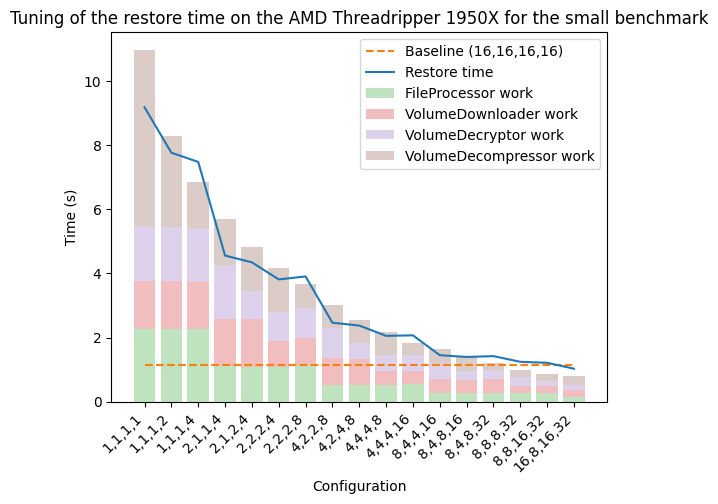

In [8]:
# Tuning plot

def plot_tuning(host_idx, size):
    tuning = dict()
    with open(f'times/{hosts[host_idx]}_{size}_tuning.csv', 'r') as f:
        keys = f.readline().strip().split(';')
        for line in f.readlines():
            line = line.strip().split(';')
            for key, value in zip(keys, line):
                if key not in tuning: tuning[key] = []
                tuning[key].append(float(value))

    for key in keys[4:]:
        tuning[key] = np.array(tuning[key]) / 1000

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    xticks = [','.join(map(str, map(int, z))) for z in zip(tuning[keys[0]], tuning[keys[1]], tuning[keys[2]], tuning[keys[3]])]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_FileProcessor'][:-1], label='FileProcessor work', alpha=.3, color=colors[2])
    prev = tuning['work_FileProcessor'][:-1]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_VolumeDownloader'][:-1], bottom=prev, label='VolumeDownloader work', alpha=.3, color=colors[3])
    prev = prev + tuning['work_VolumeDownloader'][:-1]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_VolumeDecryptor'][:-1], bottom=prev, label='VolumeDecryptor work', alpha=.3, color=colors[4])
    prev = prev + tuning['work_VolumeDecryptor'][:-1]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_VolumeDecompressor'][:-1], bottom=prev, label='VolumeDecompressor work', alpha=.3, color=colors[5])
    plt.hlines(tuning['wall_clock_restore'][-1], 0, len(tuning['wall_clock_restore'])-2, colors='r', linestyles='dashed', label=f'Baseline ({xticks[-1]})', color=colors[1])
    plt.plot(tuning['wall_clock_restore'][:-1], label='Restore time', color=colors[0])
    plt.xticks(np.arange(len(tuning[keys[0]])-1), xticks[:-1], rotation=45, ha='right')
    plt.ylabel('Time (s)')
    plt.xlabel('Configuration')
    plt.legend()
    plt.title(f'Tuning of the restore time on the {hosts_labels[host_idx]} for the {size} benchmark')
    plt.show()

plot_tuning(2, 'small')

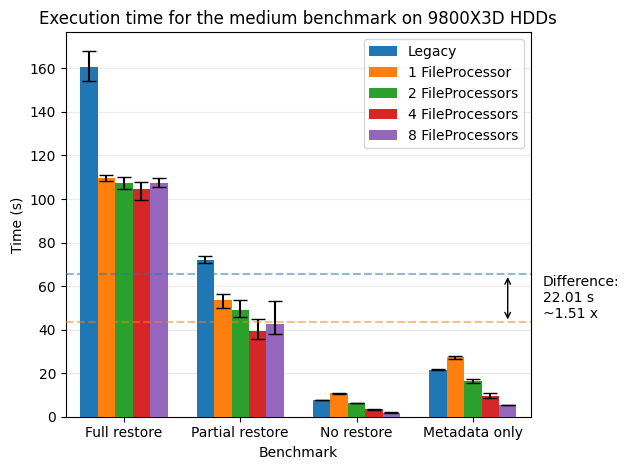

In [ ]:
# Load the regular runs
host_prefix = 'Carl9800HDD'
hosts = [f'{host_prefix}{2**i}' for i in range(4)]
for h in hosts:
    runs[h] = dict()
    runs[h]['medium'] = dict()
    for benchmark in benchmarks:
        runs[h]['medium'][benchmark] = dict()
        with open(f'{base_dir}/{h}_medium_{benchmark}_false.csv', 'r') as f:
            lines = np.array([float(line.strip()) for line in f.readlines()])
            runs[h]['medium'][benchmark]['false'] = lines / 1000

for benchmark in benchmarks:
    with open(f'{base_dir}/{host_prefix}8_medium_{benchmark}_true.csv', 'r') as f:
        lines = np.array([float(line.strip()) for line in f.readlines()])
        runs[f'{host_prefix}8']['medium'][benchmark]['true'] = lines / 1000

def clean(times):
    if len(times) == 1:
        return times[0], times[0], times[0]
    no_outliers = np.sort(times)[1:-1]
    return np.mean(no_outliers), np.min(no_outliers), np.max(no_outliers)

def plot_bars_hdd(means, mins, maxs, label, pos):
    width = .15
    off = -(2*width) + pos * width

    plt.bar(np.arange(len(benchmarks)) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=width, label=label, zorder=3)

def get_stats(run, legacy):
    means = []
    mins = []
    maxs = []
    for b in benchmarks:
        mean, mi, ma = clean(run[b][legacy])
        means.append(mean)
        mins.append(mi)
        maxs.append(ma)
    return np.array(means), np.array(mins), np.array(maxs)

means, mins, maxs = get_stats(runs[f'{host_prefix}8']['medium'], 'true')
legacy_mean = np.mean(means)
plot_bars_hdd(np.array(means), np.array(mins), np.array(maxs), f'Legacy', 0)
new_means = []
for i, host in enumerate(hosts[:]):
    means, mins, maxs = get_stats(runs[host]['medium'], 'false')

    new_means.append(np.mean(means))
    plot_bars_hdd(np.array(means), np.array(mins), np.array(maxs), f'{host[-1]} FileProcessor{"s" if i > 0 else ""}', i+1)
new_means = np.mean(new_means)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.xticks(np.arange(len(benchmarks)), benchmarks_labels)
plt.legend()
plt.xlim(-.5, len(benchmarks)-.5)
plt.ylabel('Time (s)')
plt.xlabel('Benchmark')
plt.title(f'Execution time for the medium benchmark on 9800X3D HDDs')
plt.hlines(legacy_mean, -.5, len(benchmarks)-.5, colors=colors[0], alpha=.5, linestyles='dashed', label='Legacy mean', zorder=4)
plt.hlines(new_means, -.5, len(benchmarks)-.5, colors=colors[1], alpha=.5, linestyles='dashed', label='New mean', zorder=4)
average_speedup = legacy_mean/new_means
plt.annotate('', xy=(3.3, new_means), xytext=(3.3, legacy_mean), arrowprops=dict(arrowstyle='<->', color='black'))
plt.text(3.6, (legacy_mean+new_means)/2, f'Difference:\n{np.abs(new_means-legacy_mean):.2f} s\n~{average_speedup:.2f} x', verticalalignment='center', horizontalalignment='left')
plt.grid(axis='y', alpha=.25, zorder=0)
plt.tight_layout()
plt.savefig(f'{figures_dir}/hdd_medium.png', dpi=300)
#plt.show()


[109.528125 107.22425  104.54925  107.141625] [108.099 104.611  99.563 105.668] [111.093 109.922 107.92  109.822]
[109.041875 107.539375 105.58575  101.999625] [106.035 106.163 101.736  92.997] [111.299 108.78  107.29  107.226]


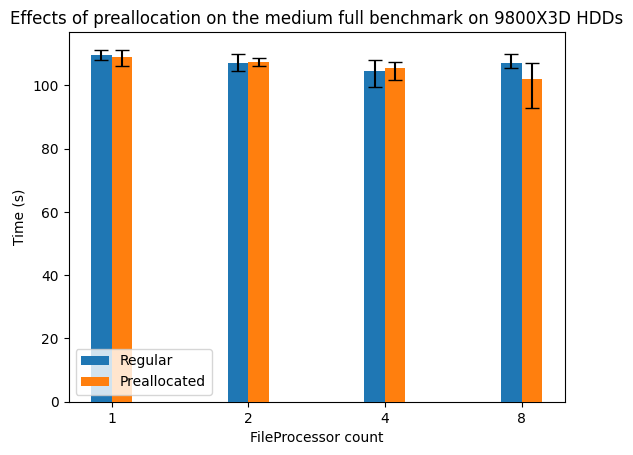

In [ ]:
# Load runs
n_fps = [2 ** i for i in range(4)]
host_prefix = 'Carl9800HDD'
hosts_normal = [f'{host_prefix}{n_fp}' for n_fp in n_fps]
hosts_pre = [f'{host_prefix}{n_fp}pre' for n_fp in n_fps]
for h in hosts_normal + hosts_pre:
    runs[h] = dict()
    runs[h]['medium'] = dict()
    runs[h]['medium']['full'] = dict()
    with open(f'{base_dir}/{h}_medium_full_false.csv', 'r') as f:
        lines = np.array([float(line.strip()) for line in f.readlines()])
        runs[h]['medium']['full']['false'] = lines / 1000

def plot_bars_hdd_pre(postfix, pos):
    means = []
    mins = []
    maxs = []
    for host in hosts_normal:
        mean, mi, ma = clean(runs[f'{host}{postfix}']['medium']['full']['false'])
        means.append(mean)
        mins.append(mi)
        maxs.append(ma)
    means = np.array(means)
    mins = np.array(mins)
    maxs = np.array(maxs)

    width = .15
    off = -(.5*width) + pos * width

    print (means, mins, maxs)

    plt.bar(np.arange(len(means)) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=width, label='Regular' if postfix == '' else 'Preallocated', zorder=3)

plot_bars_hdd_pre('', 0)
plot_bars_hdd_pre('pre', 1)
plt.legend()
plt.ylabel('Time (s)')
plt.xlabel('FileProcessor count')
plt.title(f'Effects of preallocation on the medium full benchmark on 9800X3D HDDs')
plt.xticks(np.arange(len(n_fps)), n_fps)
plt.savefig(f'{figures_dir}/hdd_medium_pre.png', dpi=300)

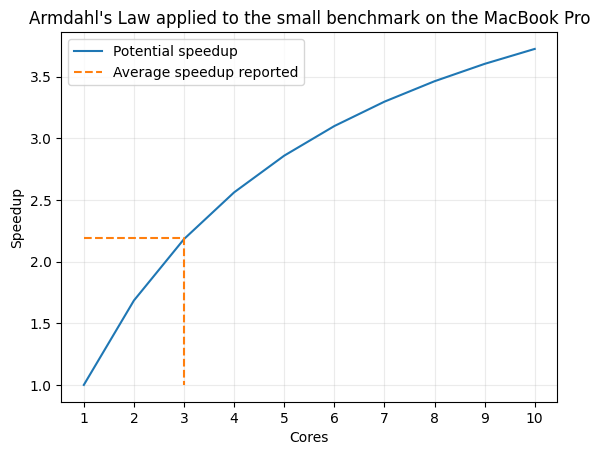

In [ ]:
def speedup(time_total, time_parallelizable, cores):
    part = time_parallelizable / time_total
    return 1 / ((1 - part) + (part / cores))

def plot_speedup():
    time_total = 7408
    time_seq = 6021

    cores = np.arange(1, 11)
    speedups = list(map(lambda x: speedup(time_total, time_seq, x), cores))
    plt.plot(cores, speedups, label='Potential speedup')
    plt.plot([1, 3, 3], [2.19] * 2 + [1], label='Average speedup reported', linestyle='dashed')
    plt.xlabel('Cores')
    plt.ylabel('Speedup')
    plt.title('Armdahl\'s Law applied to the small benchmark on the MacBook Pro')
    plt.grid(alpha=.25)
    plt.legend()
    plt.xticks(cores)

plot_speedup()
#plt.show()
plt.savefig(f'{figures_dir}/macbook_small_speedup.png', dpi=300)